# **Sentiment analysis ภาษาไทย**

## **Content**
1.   Import data and python packages
2.   Read Dataset
3.   Exploratory Data Analysis
4.   Machine learning
        
  4.1  Cleaning and Preprocessing data

  4.2   Train model
5.   Recurrent Neural Network

  5.1  Text Preprocessing

  5.2  create GRU model

  5.3  Train model
6.  Evaluation 

7.  Conclusion

  












## **Introduction**
Sentiment analysis ภาษาไทย : เป็นส่วนหนึ่งของงานด้าน NLP ( Natural Language Processing ) โดยการวิเคราะห์อารมณ์และความรู้สึกของจากประโยคหรือคำต่างๆที่เป็นภาษาไทย โดยจำแนกอารมณ์และความรู้สึกเป็นแบบสองทางคือ ความรู้สึกดี(Positive) และ ความรู้สึกไม่ดี(์Negative) ถูกนำไปใช้ในด้านจิตวิทยาในทางด้านการตลาด หรือการลงทุน เช่น การพัฒนาผลิตภัณฑ์ให้ตอบสนองกับพฤติกรรมของลูกค้า หรือการวิเคราะห์อารมณ์ความรู้สึกจากข่าวหุ้น


## Import data and python packages

In [ ]:
!pip install pythainlp
!pip install stop_words
! git clone 'http://gitlab.cpsudevops.com/nuttachot/sentiment_dataset.git'
! git clone 'https://github.com/jeffmcneill/thai-font-collection.git'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample 

import re
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pythainlp import word_vector

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, GRU
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import pickle

## **Read Dataset**

ข้อมูลจากคลังข้อมูลอารมณ์ความรู้สึกภาษาไทยจาก Gitlab ของคุณ [Nuttachot Promrit](https://gitlab.cpsudevops.com/nuttachot/sentiment_dataset)

In [2]:
train_path = './sentiment_dataset/train.txt'
train_label_path = './sentiment_dataset/train_label.txt'
test_path = './sentiment_dataset/test.txt'
test_label_path = './sentiment_dataset/test_label.txt'

with open(train_path, 'r', encoding='utf8') as f:
  lines = f.readlines()
list_train=[e.strip() for e in lines]
del lines
f.close()

with open(train_label_path, 'r', encoding='utf8') as f:
  lines = f.readlines()
list_train_label=[e.strip() for e in lines]
del lines
f.close()

with open(test_path, 'r', encoding='utf8') as f:
  lines = f.readlines()
list_test=[e.strip() for e in lines]
del lines
f.close()

with open(test_label_path, 'r', encoding='utf8') as f:
  lines = f.readlines()
list_test_label=[e.strip() for e in lines]
del lines
f.close()

รวมข้อมูล train และ test เข้าด้วยกันและตัดข้อมูลที่เป็นคำถาม และคำที่เป็นกลางออก

In [3]:
Sentiment = list_train + list_test
Label_sentiment = list_train_label + list_test_label
df_sentiment = pd.DataFrame({'SentimentText' : Sentiment, 'Sentiment' : Label_sentiment})
df_sentiment = df_sentiment[df_sentiment['Sentiment'] != 'q']
df_sentiment = df_sentiment[df_sentiment['Sentiment'] != 'neu']
df_sentiment.head()

,SentimentText,Sentiment
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
6,เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ต...,neg
8,เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ,neg
10,สนใจ ฟอจูนเนอร์ สีขาวครับ,pos
11,ลิปมันของเเบร์น Mistine ราคากลาง ๆ ไม่แพงมาก ร...,neg


## Exploratory Data Analysis

แสดงข้อมูลจำนวนจำนวนด้วย countplot

จาก countplot จะเห็นว่าคำที่เป็น negative จะมากกว่าคำที่เป็น positive 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


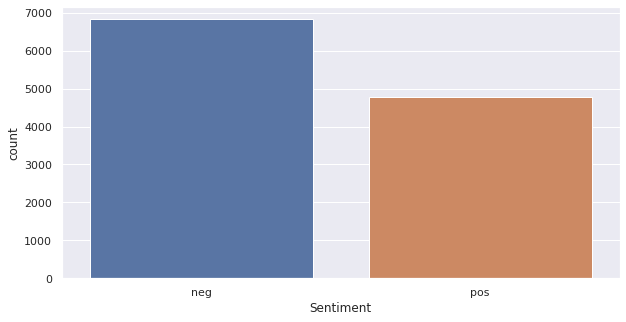

In [4]:
sns.set_theme(style="darkgrid")
fig = plt.figure(1, figsize=(10,5))
ax = sns.countplot(df_sentiment.Sentiment)
plt.show()

แสดงข้อมูลคำด้วย Wordcloud

แสดงรายละเอียดของคำที่ใช้ทั้ง positive และ negative ด้วย Wordcloud จะเห็นว่าจากการแสดงข้อมูลคำจาก wordcloud คำส่วนใหญ่จะเป็นชื่อแบนด์ที่เป็นภาษาอังกฤษ ซึ่งไม่มีส่วนในการวิเคราะห์อารมณ์ความรู้สึก จึงต้องตัดออก

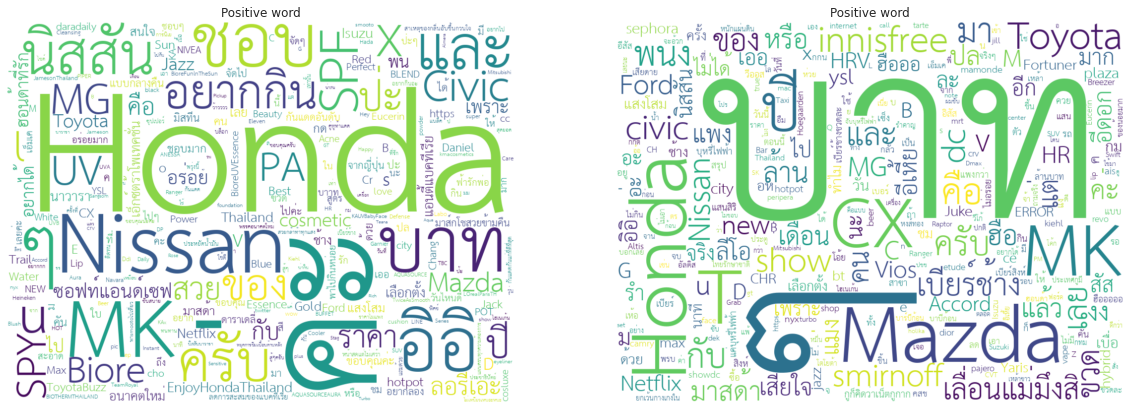

In [5]:
front = './thai-font-collection/downloadable-free-thai-fonts/dip-sipa/TH-Sarabun-New-Regular.ttf'
wordcloud_pos = WordCloud(font_path=front,
                      max_words=300,
                      contour_width=3,
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      width=1024, 
                      height=768,
                      collocations=False,
                      ).generate(' '.join(df_sentiment[df_sentiment['Sentiment'] == 'pos']['SentimentText']))

wordcloud_neg = WordCloud(font_path=front,
                      max_words=300,
                      contour_width=3,
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+",
                      width=1024, 
                      height=768,
                      collocations=False,
                      ).generate(' '.join(df_sentiment[df_sentiment['Sentiment'] == 'neg']['SentimentText']))            

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(wordcloud_pos, cmap=plt.cm.gray, interpolation='bilinear')
ax2.imshow(wordcloud_neg, cmap=plt.cm.gray, interpolation='bilinear')
ax1.set_title('Positive word')
ax2.set_title('Positive word')
ax1.axis("off")
ax2.axis("off")
plt.show()        

## **Machine learning**

### Cleaning and Preprocessing data

ทำความสะอาดข้อมูลด้วย

*   ตัดคำที่ไม่ใช้ภาษาไทยออก
*   ตัด http link ออก
*   ตัดแบ่งคำภาษาไทย
*   ตัดคำที่เป็นตัวเลขออก


In [6]:

def split_word(text):
    """Clean and split word 
    """
    tokens = re.sub(r'[^ก-๙]', "", text)
    tokens = re.sub(r"http\S+", "", text)

    tokens = word_tokenize(text, engine='newmm')

    tokens = [i for i in tokens if not i.isnumeric()]

    return tokens

    #Tokenize Text and clean data
tokens_list = [split_word(txt) for txt in df_sentiment['SentimentText']]
tokens_list_j = [','.join(tkn) for tkn in tokens_list]

เตรียมข้อมูล


*   สร้างคลังคำศัพท์และfeature ด้วย tfidf
*   ทำ Label Encoder
*   แบ่งข้อมูลเป็น train และ test



In [7]:
#Vectorization
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','))
tvec.fit(tokens_list_j)
t_feat = tvec.transform(tokens_list_j)
text_transformed = pd.DataFrame(t_feat.toarray(), columns=tvec.get_feature_names())

#Label Encoder
le = LabelEncoder()
le.fit(df_sentiment.Sentiment)
y = le.transform(df_sentiment.Sentiment)
X = text_transformed

#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2475)

### Train model




**MultinomialNB**

การ train model จากข้อมูลที่อยู่ในรูปแบบ text จะต้องใช้ Naive Bayes ที่เหมาะสำหรับการทำนายข้อมูลในรูปแบบความถี่ของคำที่อยู่ในเอกสาร โดยใช้เรื่องความน่าจะเป็นมาใช้ในการทำนาย


In [8]:
#MultinomialNB
MNB = MultinomialNB().fit(X_train, y_train)
print('Accuracy MultinomialNB on the train set: ', MNB.score(X_train, y_train))
print('Accuracy MultinomialNB on the test set: ', MNB.score(X_test, y_test))

Accuracy MultinomialNB on the train set:  0.8397629310344827
Accuracy MultinomialNB on the test set:  0.7858681602757432


**LogisticRegression**

Logistic Regression เป็นโมเดลที่เหมาะสำหรับใช้ในการทำ classification ที่แก้ปัญหาแบบไบนารี่ สำหรับในโปรเจคนี้จะเป็นการทำนายข้อความว่าเป็น Positive หรือ Negative จึงนำLogistic Regression มาใช้ในงานนี้

In [9]:
#LogisticRegression
log_reg = LogisticRegression(C=6).fit(X_train, y_train)
print('Accuracy LogisticRegression on the train set: ', log_reg.score(X_train, y_train))
print('Accuracy LogisticRegression on the test set: ', log_reg.score(X_test, y_test))

Accuracy LogisticRegression on the train set:  0.9578663793103448
Accuracy LogisticRegression on the test set:  0.8392934080137872


# **Recurrent Neural Network**

การใช้ Neural Network มาใช้ในงานที่อยู่ในรูปแบบ text จึงจำเป็นต้องใช้ Recurrent Neural Network เนื่องจากการทำงานของ RNN นี้สามารถใช้ในรูปแบบงานที่่เป็น Sequence ได้อย่างดี


**Text Preprocessing**

เรียกใช้และสร้างคลังคำศัพท์ Word Embedding จาก Thai2Vec

In [10]:
model_vec = word_vector.get_model()
thai2dict = {}
for word in model_vec.index2word:
    thai2dict[word] = model_vec[word]
thai2vec = pd.DataFrame.from_dict(thai2dict, orient='index')
vocab = thai2vec.index.to_list()

หา maxlen ของตัวอย่างที่มากที่สุด

In [11]:
def sent2idx(x):
  """Decoding the predictions from the model 
    """
  xidx = []
  for w in x:
    if w in vocab:
      xidx.append(vocab.index(w))
  return np.array(xidx)

X_idx = []
maxlen = 0
for x in tokens_list_j:
  X_idx.append(sent2idx(x))
  if len(X_idx[-1]) > maxlen:
    maxlen = len(X_idx[-1])
print('Maxlen of sample : ', maxlen)

Maxlen of sample :  2414


ปรับขนากมิติให้ทุกตัวอย่างเท่ากับ Maxlen

In [12]:
for i, x in enumerate(X_idx):
  if len(x) < maxlen:
    X_idx[i] = np.hstack((x, np.zeros(maxlen-len(x))))
X_idx = np.array(X_idx)

แบ่งข้อมูลให้เป็น train และ test

In [13]:
X_train_GRU, X_test_GRU, y_train_GRU, y_test_GRU = train_test_split(X_idx, y, test_size=0.1, random_state=2475)

**Build Model**

In [14]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(thai2vec.shape[0], thai2vec.shape[1], name='embed'))
model.add(keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True, activation = "relu")))
model.add(keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=False, activation = "relu")))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.get_layer('embed').set_weights([thai2vec])
early_stopping_monitor = EarlyStopping(patience=1, monitor='val_loss')

In [16]:

train_model = model.fit(X_train_GRU, y_train_GRU,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks= [early_stopping_monitor]
                    )

Epoch 1/10
74/74 [==============================] - 1597s 21s/step - loss: 0.6440 - accuracy: 0.6200 - val_loss: 0.5275 - val_accuracy: 0.7433
Epoch 2/10
74/74 [==============================] - 1596s 22s/step - loss: 0.4993 - accuracy: 0.7731 - val_loss: 0.4945 - val_accuracy: 0.7720
Epoch 3/10
74/74 [==============================] - 1467s 20s/step - loss: 0.4645 - accuracy: 0.7858 - val_loss: 0.4773 - val_accuracy: 0.7845
Epoch 4/10
74/74 [==============================] - 1461s 20s/step - loss: 0.4170 - accuracy: 0.8130 - val_loss: 0.4427 - val_accuracy: 0.7960
Epoch 5/10
74/74 [==============================] - 1515s 20s/step - loss: 0.3767 - accuracy: 0.8413 - val_loss: 0.4725 - val_accuracy: 0.7969


In [23]:
def decode_sentiment(score):
  """Decoding the predictions from the model 
    """
  if score >= 0.5:
    label = 1
  else:
    label = 0
  return label

### **Evaluation**

Text(66.5, 0.5, 'True label')

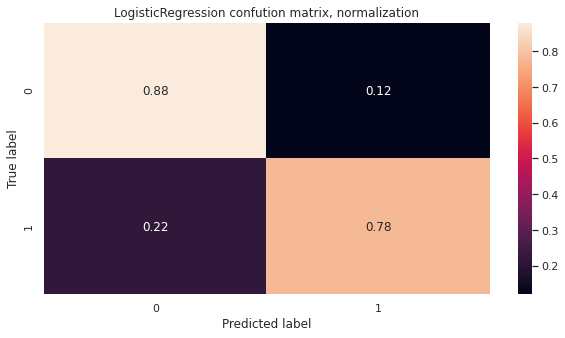

In [18]:
y_pred_log = log_reg.predict(X_test)
plt.figure(figsize=(10, 5))
cf_matrix_log = confusion_matrix(y_test, y_pred_log, normalize='true')
sns.heatmap(cf_matrix_log, annot=True)
plt.title('LogisticRegression confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

Text(66.5, 0.5, 'True label')

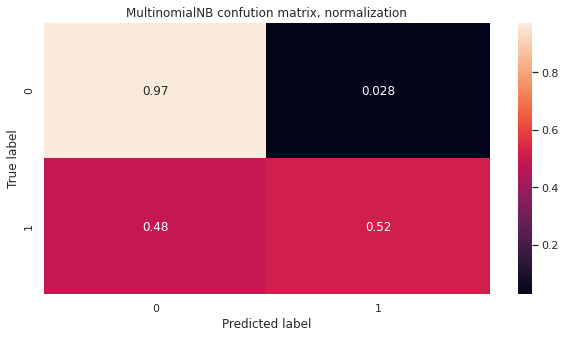

In [19]:
y_pred_MNB = MNB.predict(X_test)
plt.figure(figsize=(10, 5))
cf_matrix_MNB = confusion_matrix(y_test, y_pred_MNB, normalize='true')
sns.heatmap(cf_matrix_MNB, annot=True)
plt.title('MultinomialNB confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

Text(66.5, 0.5, 'True label')

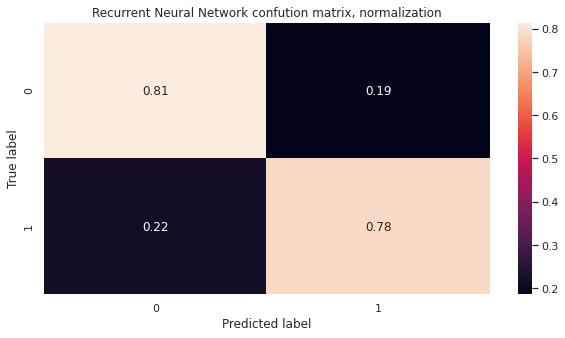

In [22]:
y_pred_rnn = model.predict(X_test_GRU)
y_pred_rnn = [decode_sentiment(score) for score in y_pred_rnn]
plt.figure(figsize=(10, 5))
cf_matrix = confusion_matrix(y_test_GRU, y_pred_rnn, normalize='true')
sns.heatmap(cf_matrix, annot=True)
plt.title('Recurrent Neural Network confution matrix, normalization')
plt.xlabel('Predicted label')
plt.ylabel('True label')

## **Conclusion**

จากการนำ Model ทั้งสามแบบมาทำนายอารมณ์ความรู้สึกที่เป็นภาษาไทย จะเห็นว่าประสิทธิภาพของโมเดลนั้นเป็นที่น่าพึงพอใจอยู่ในระดับที่ดี สามารถพอที่จะนำมาใช้ได้ ในส่วนของการใช้ RNN เข้ามาใช้พบประสิทธิภาพของโมเดลที่ซับซ้อนอาจจะไม่แตกต่างกับโมเดลพื้นฐานทั่วไปมากนัก จะเห็นได้ว่าการใช้ Logistic Regression เข้ามาใช้อาจจะได้ประสิทธิภาพที่เทียบเท่าหรือดีกว่า โดยไม่ต้องใช้ทรัพยากรในการประมวลผลมากในงานนี้